In [2]:
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta


# Importar datos

In [3]:
START_DATE = (datetime.now()-timedelta(50)).strftime('%Y-%m-%d')
END_DATE = datetime.now().strftime('%Y-%m-%d')
STOCK = 'AMZN'

def get_data(ticker):
	try:
		stock_data = data.DataReader(ticker, 'yahoo', START_DATE, END_DATE)
	except RemoteDataError:
		print('No data found for {t}'.format(t=ticker))
	return stock_data


In [4]:
df=get_data(STOCK)
df.head()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-09-18,3037.800049,2905.540039,3031.739990,2954.909912,8892600,2954.909912
2020-09-21,2962.000000,2871.000000,2906.500000,2960.469971,6117900,2960.469971
2020-09-22,3133.989990,3000.199951,3033.840088,3128.989990,6948800,3128.989990
2020-09-23,3127.000000,2992.379883,3120.429932,2999.860107,5652700,2999.860107
2020-09-24,3069.300049,2965.000000,2977.790039,3019.790039,5529400,3019.790039


# Transformaciòn de los datos y calculo indicadores


In [5]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,36.000000,36.000000,36.000000,36.000000,3.600000e+01,36.000000
mean,3231.321933,3133.336663,3187.925001,3184.095527,5.445200e+06,3184.095527
std,122.277048,122.637271,121.491385,122.337071,1.369351e+06,122.337071
min,2962.000000,2871.000000,2906.500000,2954.909912,3.174100e+06,2954.909912
25%,3173.030029,3072.250000,3139.604919,3118.739990,4.571950e+06,3118.739990
50%,3218.439941,3140.425049,3190.435059,3193.119995,5.223500e+06,3193.119995
75%,3289.657471,3192.192505,3231.067505,3249.047424,5.955375e+06,3249.047424
max,3496.239990,3424.219971,3467.989990,3443.629883,8.892600e+06,3443.629883


In [6]:
def media_movil(num,df,column):
  df['media_{}_{}'.format(column,num)]=df[column].rolling(window=int(num),min_periods=1).mean()
  return df

In [9]:
medias=['16','42']
for m in medias:
  df=media_movil(m,df,'Close')


In [10]:
df['diff']=df.Close.diff(periods=1)
df.dropna(inplace=True)
df['sub']=df['diff'][df['diff']>0]
df['baj']=abs(df['diff'][df['diff']<=0])
df.fillna(value=0,inplace=True)
df['media_sub_14']=df['sub'].rolling(window=14).mean()
df['media_baj_14']=df['baj'].rolling(window=14).mean()
df['RSI']=100-(100/(1+(df.media_sub_14/df.media_baj_14)))
df.dropna(inplace=True)
df.drop(columns=['diff','sub','baj','media_sub_14','media_baj_14'],inplace=True)

In [11]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close,RSI,media_Close_16,media_Close_42
count,8.000000,8.000000,8.000000,8.000000,8.000000e+00,8.000000,8.000000,8.000000,8.000000
mean,3222.066254,3117.147491,3184.148743,3167.169983,6.249512e+06,3167.169983,39.913064,3226.475064,3241.180384
std,106.507736,121.605352,107.701541,125.311039,1.259945e+06,125.311039,13.592373,31.048786,15.830875
min,3074.899902,2950.120117,3018.530029,3004.479980,4.641300e+06,3004.479980,21.670318,3193.337479,3225.525750
25%,3145.177490,3009.494995,3133.747498,3045.344910,5.415700e+06,3045.344910,27.168654,3196.997620,3229.725049
50%,3251.050049,3151.099976,3180.630005,3186.895020,6.192900e+06,3186.895020,44.705762,3222.632462,3234.944562
75%,3278.515015,3181.000000,3263.135010,3258.712463,6.943600e+06,3258.712463,49.321980,3255.009335,3252.271976
max,3366.800049,3288.879883,3319.969971,3322.000000,8.386400e+06,3322.000000,56.008313,3265.662630,3265.662630


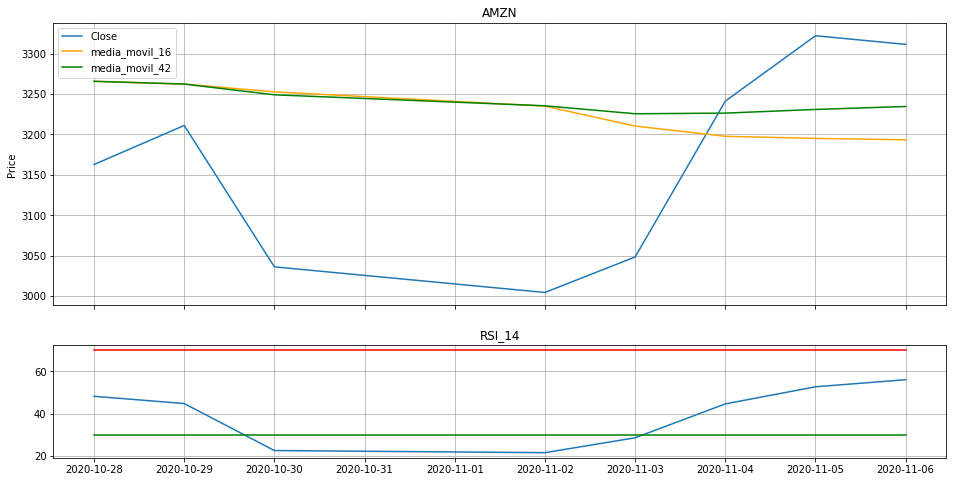

In [12]:
# using the variable ax for single a Axes
fig, ax = plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios': [2.5, 1]}, figsize=(16,8))


ax[0].plot(df.Close)
ax[0].plot(df.media_Close_16,'orange')
ax[0].plot(df.media_Close_42,'g')
ax[0].set_title(STOCK)
ax[0].set_ylabel('Price')
ax[0].legend(['Close','media_movil_16','media_movil_42'])
ax[0].grid(True)


ax[1].plot(df.RSI)
ax[1].plot(df.index,70*np.ones(df.shape[0]),'r')
ax[1].plot(df.index,30*np.ones(df.shape[0]),'g')
ax[1].set_title('RSI_14')
ax[1].grid(True)




plt.show()


# Implementaciòn Estrategia

In [ ]:
MR=df.media_Close_16.values[-2:]
ML=df.media_Close_42.values[-2:]
rsi=df.RSI[-1]
close=df.Close.values[-2:]

In [ ]:
def Crossover(MR,ML):
  if (MR[0]<ML[0] and MR[1]>=ML[1]):
    return True
  else:
    return False
def RSI_umbral(rsi):
  if rsi<30:
    return True
  else:
    return False

In [ ]:
print(Crossover(MR,ML))
print(RSI_umbral(rsi))
print(Crossover(MR,close))

False
False
False


In [ ]:
buy_sign_SMA=Crossover(MR,ML)
buy_sign_RSI=RSI_umbral(rsi)
sell_sign_SMA=Crossover(MR,close)


# Llamada a la API

In [ ]:
import requests, json
API_KEY='PKSV7UHBVU01KTP5GPY4'
SECRET_KEY='D12wf12S8oYnsOaI03ynQ8lfODzeZ87Q7wV1gBZR'
BASE_URL = "https://paper-api.alpaca.markets"
ACCOUNT_URL = "{}/v2/account".format(BASE_URL)
ORDERS_URL = "{}/v2/orders".format(BASE_URL)
OPEN_POSITION = "{}/v2/positions".format(BASE_URL)
HEADERS = {'APCA-API-KEY-ID': API_KEY, 'APCA-API-SECRET-KEY': SECRET_KEY}

def get_account():
    r = requests.get(ACCOUNT_URL, headers=HEADERS)

    return json.loads(r.content)


def create_order(symbol, qty, side, type, time_in_force):
    data = {
        "symbol": symbol,
        "qty": qty,
        "side": side,
        "type": type,
        "time_in_force": time_in_force
    }

    r = requests.post(ORDERS_URL, json=data, headers=HEADERS)

    return json.loads(r.content)

def get_orders():
    r = requests.get(ORDERS_URL, headers=HEADERS)

    return json.loads(r.content)

def get_cash():
  return float(get_account().get('cash'))
  
def get_open_positions():
  r = requests.get(OPEN_POSITION, headers=HEADERS)
  return json.loads(r.content)

def orden_pendiente(STOCK):
  #True si esperamos de completare un orden
  #else False
  for element in get_orders():
    if element.get('symbol') == STOCK:
    #print( element.get('status'))
      if element.get('status') == 'filled':
        print("La orden ha sido aceptada")
        return False
      else:
        return True
    else:
      return False

def position(STOCK):
  for element in  get_open_positions():
    if element.get('symbol') == STOCK:
      #print(element.get('qty'))
      return int(element.get('qty')) #numero posiziones abiertas en esta empresa
    else:
      return 0
  return 0

In [ ]:
buy_sign_SMA=True

In [ ]:
def Bot(STOCK):
  if orden_pendiente(STOCK):
    return 0
  if position(STOCK)>0:
    if sell_sign_SMA:
        create_order(STOCK, position(STOCK) , 'sell', 'market', 'gtc') #sell
  else:
    if (buy_sign_SMA or buy_sign_RSI):
      qty=int(get_cash()/close[-1])
      create_order(STOCK, qty, 'buy', 'market', 'gtc') #buy



In [ ]:
Bot('TSLA')

In [ ]:
print(position('AMZN'))

In [ ]:
get_open_positions()

[{'asset_class': 'us_equity',
  'asset_id': '8ccae427-5dd0-45b3-b5fe-7ba5e422c766',
  'avg_entry_price': '434.93',
  'change_today': '0.032970687443584',
  'cost_basis': '12612.97',
  'current_price': '434.86',
  'exchange': 'NASDAQ',
  'lastday_price': '420.98',
  'market_value': '12610.94',
  'qty': '29',
  'side': 'long',
  'symbol': 'TSLA',
  'unrealized_intraday_pl': '-2.03',
  'unrealized_intraday_plpc': '-0.000160945439496',
  'unrealized_pl': '-2.03',
  'unrealized_plpc': '-0.000160945439496'}]

In [ ]:
get_orders()

[{'asset_class': 'us_equity',
  'asset_id': 'f801f835-bfe6-4a9d-a6b1-ccbb84bfd75f',
  'canceled_at': None,
  'client_order_id': '31f67473-06c4-4e84-844d-9825b98b119a',
  'created_at': '2020-11-05T20:05:10.123329Z',
  'expired_at': None,
  'extended_hours': False,
  'failed_at': None,
  'filled_at': None,
  'filled_avg_price': None,
  'filled_qty': '0',
  'hwm': None,
  'id': '31c4680e-c22e-47e8-8deb-2a9b74ae7cf6',
  'legs': None,
  'limit_price': '180',
  'order_class': '',
  'order_type': 'limit',
  'qty': '10',
  'replaced_at': None,
  'replaced_by': None,
  'replaces': None,
  'side': 'buy',
  'status': 'new',
  'stop_price': None,
  'submitted_at': '2020-11-05T20:05:10.116771Z',
  'symbol': 'AMZN',
  'time_in_force': 'gtc',
  'trail_percent': None,
  'trail_price': None,
  'type': 'limit',
  'updated_at': '2020-11-05T20:05:10.206869Z'},
 {'asset_class': 'us_equity',
  'asset_id': 'f801f835-bfe6-4a9d-a6b1-ccbb84bfd75f',
  'canceled_at': None,
  'client_order_id': '38ceadb8-4a7a-442c

In [ ]:
position(STOCK)

0

In [ ]:
def create_order_limit(symbol, qty, side, type, time_in_force,limit_price):
    data = {
        "symbol": symbol,
        "qty": qty,
        "side": side,
        "type": type,
        "time_in_force": time_in_force,
        "limit_price": limit_price

    }
    r = requests.post(ORDERS_URL, json=data, headers=HEADERS)

    return json.loads(r.content)

In [ ]:
response3 =create_order_limit("AMZN", 10, "buy", "limit", "gtc",180)